# CNN for Facial Expression Recognition (FER)

In [1]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer

!pip install livelossplot
print(torchbearer.__version__)

0.5.3


### import Liberaries

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
%matplotlib inline

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.utils import plot_model
import keras.backend as K


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKerasTF
from sklearn.model_selection import KFold


from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.6.4


In [3]:
print(os.listdir("../input"))

['fer2013']


In [4]:
data = pd.read_csv('../input/fer2013/train_csv.csv')
#check data shape
data.shape

(59876, 2)

### preview first 5 row of data

In [5]:
data.head(5)

,pixels,label
0,147 143 143 141 139 139 142 148 153 150 146 14...,3
1,191 191 191 151 138 135 120 113 119 117 114 10...,4
2,121 114 103 103 93 82 78 80 85 80 75 73 69 66 ...,2
3,83 76 81 121 153 163 169 174 182 188 189 192 1...,5
4,150 150 152 152 154 158 162 159 170 112 0 0 6 ...,5


### check target labels

In [6]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
emotion_counts = data['label'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['label', 'number']
emotion_counts['label'] = emotion_counts['label'].map(emotion_map)
emotion_counts

,label,number
0,Happy,8223
1,Neutral,8965
2,Fear,8097
3,Sad,8830
4,Digust,8284
5,Angry,7966
6,Surprise,9511


### Plotting a bar graph of the class distributions

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


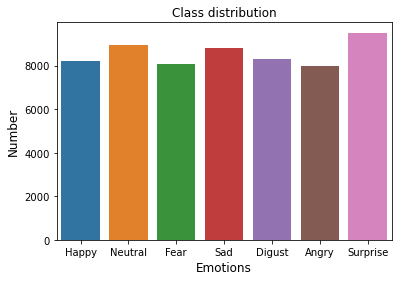

In [7]:

plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.label, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

### look at some images

In [8]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['label']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == "__main__":


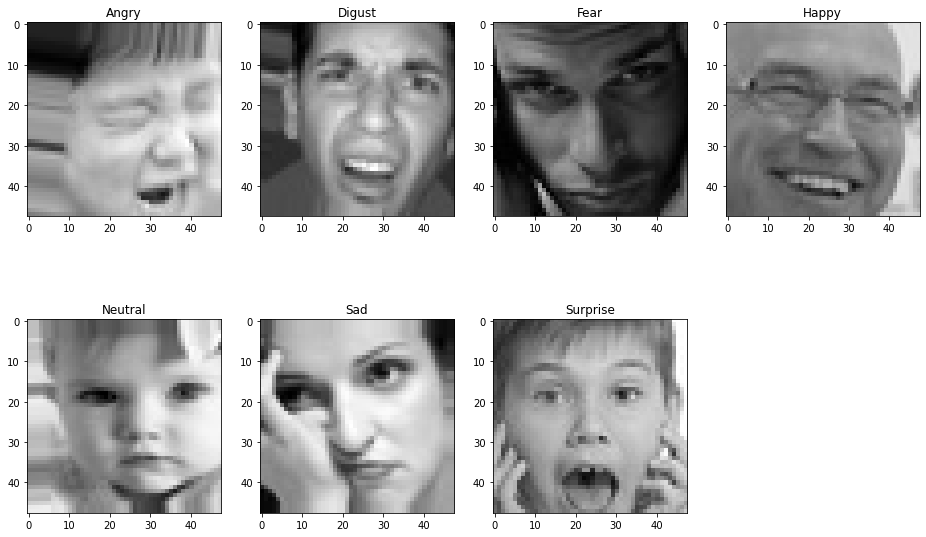

In [9]:
plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['label'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

### initilize parameters

In [10]:
BATCH_SIZE = 16
NUM_CLASSES = 7
EPOCHS = 200
LOSS_FUNCTION = 'categorical_crossentropy'
LEARNING_RATE = 0.001
IMAGE_SIZE = 48

### ImageDataGenerator variable

In [11]:
ROTATION_RANGE = 15
WIDTH_SHIFT_RANGE = 0.15
HEIGHT_SHIFT_RANGE = 0.15
SHEAR_RANGE = 0.15
ZOOM_RANGE = 0.15

### Extract X, Y data from csv file

In [12]:
def get_data(df):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,IMAGE_SIZE, IMAGE_SIZE,1)/255.0   
    data_Y = to_categorical(df['label'], NUM_CLASSES)
    print("Data X Shape: {},", "Data Y Shape: {}".format(data_X.shape, data_Y.shape) ) 
    return data_X, data_Y

In [13]:
X, Y = get_data(data)

Data X Shape: {}, Data Y Shape: (59876, 48, 48, 1)


### split data between training and validation

In [14]:
x,y = shuffle(X,Y, random_state=2)

## Creating Model

In [15]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [16]:
def create_model():
    model_1 = Sequential()

    model_1.add(Conv2D(64, (5, 5), padding='same', input_shape=(48, 48,1),kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(Conv2D(64, (5, 5), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model_1.add(Dropout(0.4))

    model_1.add(Conv2D(128, (3, 3), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(Conv2D(128, (3, 3), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model_1.add(Dropout(0.4))

    model_1.add(Conv2D(256, (3, 3), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(Conv2D(256, (3, 3), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model_1.add(Dropout(0.4))

    model_1.add(Conv2D(512, (3, 3), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(Conv2D(512, (3, 3), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model_1.add(Dropout(0.25))
    
    model_1.add(Conv2D(512, (3, 3), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(Conv2D(512, (3, 3), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model_1.add(Dropout(0.25))

    model_1.add(Flatten())

    model_1.add(Dense(512,kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(Dropout(0.4))

    model_1.add(Dense(128,kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(Dropout(0.4))

    model_1.add(Dense(64,kernel_initializer = 'he_normal'))
    model_1.add(Activation('relu'))
    model_1.add(BatchNormalization())
    model_1.add(Dropout(0.4))

    model_1.add(Dense(NUM_CLASSES, activation='softmax'))
    
    model_1.compile(loss=LOSS_FUNCTION, optimizer = Adam(LEARNING_RATE), metrics=['accuracy',
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,])
    
    return model_1

### Model Visualization

In [17]:
new_model = create_model()
new_model.summary()

2023-02-03 08:59:40.703778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 08:59:40.704877: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 08:59:40.705611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 08:59:40.707099: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0

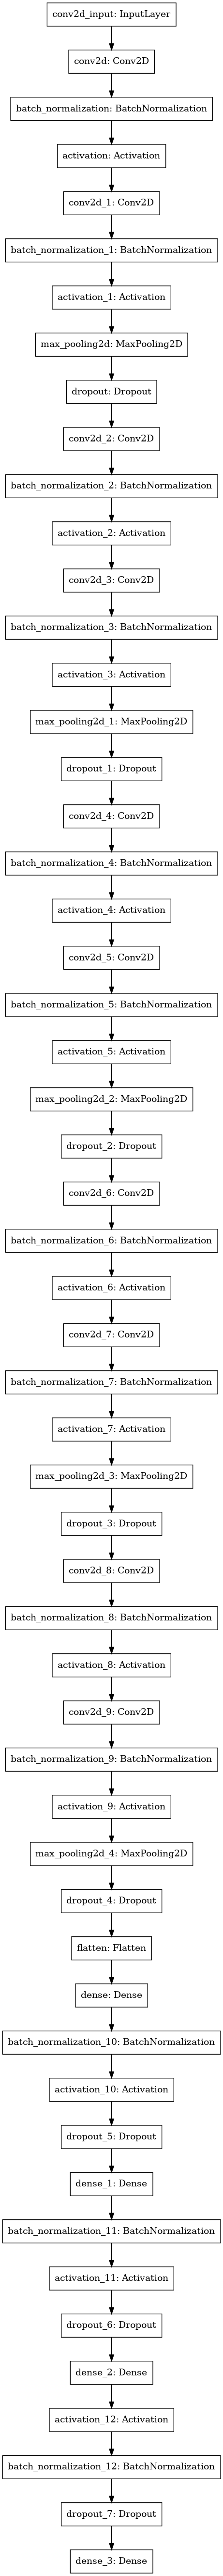

In [18]:
plot_model(new_model, to_file='v4_model.png')

### k-Fold Cross-Validation

In [19]:
kf = KFold(n_splits=4, shuffle=False)

In [20]:
train_data_generator = ImageDataGenerator(
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range = ROTATION_RANGE,
                            width_shift_range = WIDTH_SHIFT_RANGE,
                            height_shift_range = HEIGHT_SHIFT_RANGE,
                            shear_range = SHEAR_RANGE,
                            zoom_range = ZOOM_RANGE,
                            fill_mode='nearest',
                            horizontal_flip = True)

## Training Model

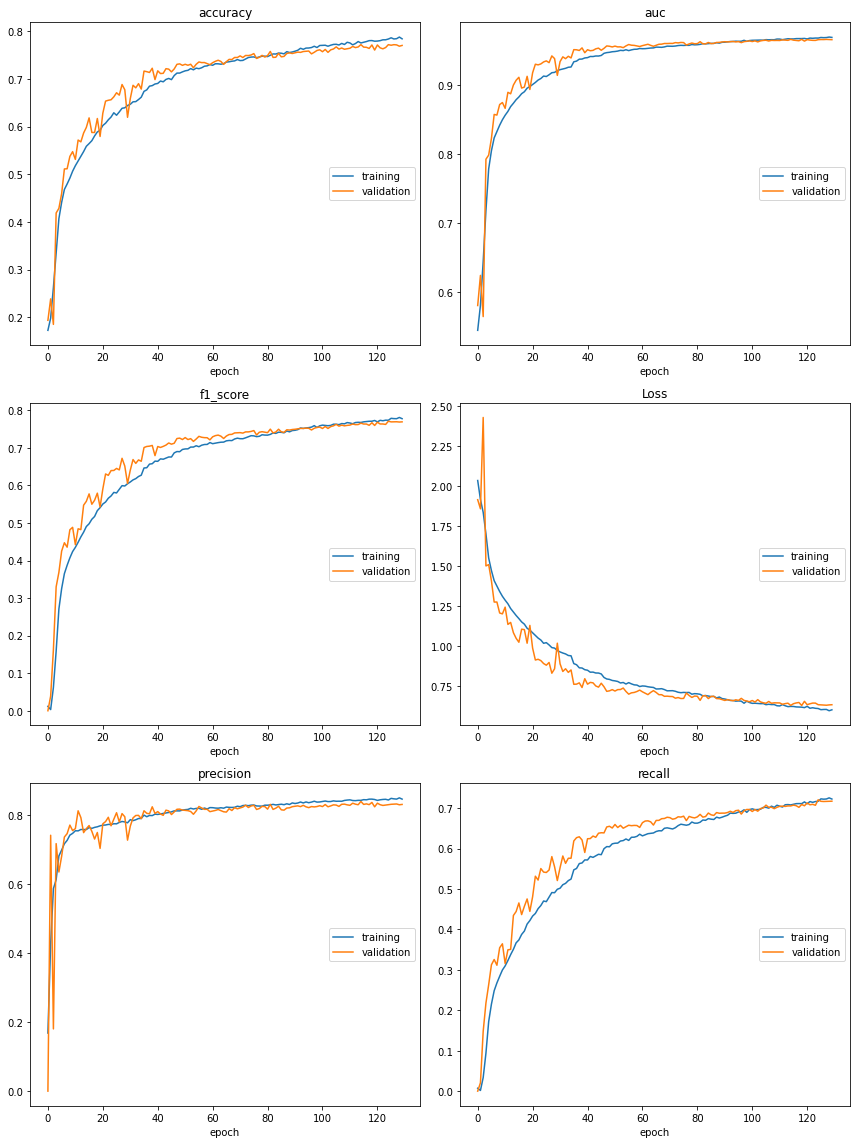

accuracy
	training         	 (min:    0.173, max:    0.788, cur:    0.784)
	validation       	 (min:    0.185, max:    0.772, cur:    0.770)
auc
	training         	 (min:    0.544, max:    0.969, cur:    0.969)
	validation       	 (min:    0.564, max:    0.966, cur:    0.965)
f1_score
	training         	 (min:    0.003, max:    0.781, cur:    0.778)
	validation       	 (min:    0.000, max:    0.771, cur:    0.769)
Loss
	training         	 (min:    0.597, max:    2.034, cur:    0.603)
	validation       	 (min:    0.630, max:    2.428, cur:    0.635)
precision
	training         	 (min:    0.168, max:    0.851, cur:    0.847)
	validation       	 (min:    0.000, max:    0.840, cur:    0.832)
recall
	training         	 (min:    0.002, max:    0.726, cur:    0.723)
	validation       	 (min:    0.000, max:    0.721, cur:    0.717)
Restoring model weights from the end of the best epoch.

Epoch 00130: val_loss did not improve from 0.62991
Epoch 00130: early stopping


In [21]:
result = []
scores_loss = []
scores_acc = []
k_no = 0
for train_index, test_index in kf.split(x):
    X_Train = x[train_index]
    Y_Train = y[train_index]
    X_Test = x[test_index]
    Y_Test = y[test_index]

    file_path = "../working/v4_weights_best_"+str(k_no)+".hdf5"
    # Callback to save Model
    checkpoint = ModelCheckpoint(
        file_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Callback to early stopping of Training
    early_stopping = EarlyStopping(
        monitor='val_loss',
        mode="min",
        min_delta=0.00005,
        patience=11,
        verbose=1,
        restore_best_weights=True,
    )

    # Callback to reduce Learning Rate
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        mode="min",
        factor=0.5,
        patience=7,
        min_lr=1e-8,
        verbose=1,
    )

    callbacks = [
        PlotLossesKerasTF(),
        early_stopping,
        lr_scheduler,
        checkpoint,
    ]

    model_1 = create_model()
    history_1 = model_1.fit(
        train_data_generator.flow(X_Train, Y_Train, BATCH_SIZE),
        steps_per_epoch=len(X_Train) / BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_Test, Y_Test),
        callbacks=callbacks,
        verbose=0)
    
    model_1.load_weights(file_path)
    result.append(model_1.predict(X_Test))
    score = model_1.evaluate(X_Test,Y_Test, verbose=0)
    scores_loss.append(score[0])
    scores_acc.append(score[1])
    k_no+=1

In [22]:
print(scores_acc,scores_loss)

[0.7800788283348083, 0.8038613200187683, 0.8022580146789551, 0.771461009979248] [0.6010566353797913, 0.5651351809501648, 0.5739654302597046, 0.6299076080322266]


### Taking model with lowest Loss

In [24]:
value_min = min(scores_loss)
value_index = scores_loss.index(value_min)
print(value_index)

1


In [25]:
model_1.load_weights("../working/v4_weights_best_"+str(value_index)+".hdf5")

In [27]:
best_model = model_1

### Evaluating model

#### Load test data

In [29]:
print(os.listdir("../input/fer2013test"))

['test_csv.csv']


In [30]:
test_data = pd.read_csv('../input/fer2013test/test_csv.csv')
#check data shape
test_data.shape

(7178, 2)

In [31]:
test_data.head(5)

,pixels,label
0,80 85 86 87 86 85 88 88 90 83 83 83 88 92 89 9...,0
1,14 13 14 16 18 22 24 21 23 22 21 21 22 24 25 2...,6
2,36 45 76 82 57 51 92 97 81 104 120 139 153 158...,4
3,52 46 51 47 57 46 56 71 80 108 127 153 174 173...,5
4,43 146 208 200 227 238 242 240 243 238 240 241...,2


In [33]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
emotion_counts = test_data['label'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['label', 'number']
emotion_counts['label'] = emotion_counts['label'].map(emotion_map)
emotion_counts

,label,number
0,Angry,958
1,Surprise,831
2,Neutral,1233
3,Sad,1247
4,Fear,1024
5,Happy,1774
6,Digust,111


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


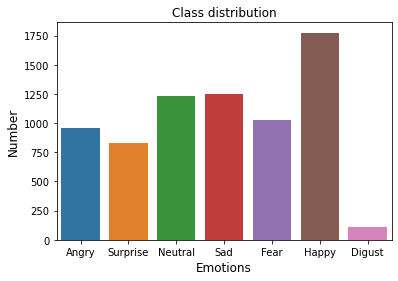

In [34]:
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.label, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == "__main__":


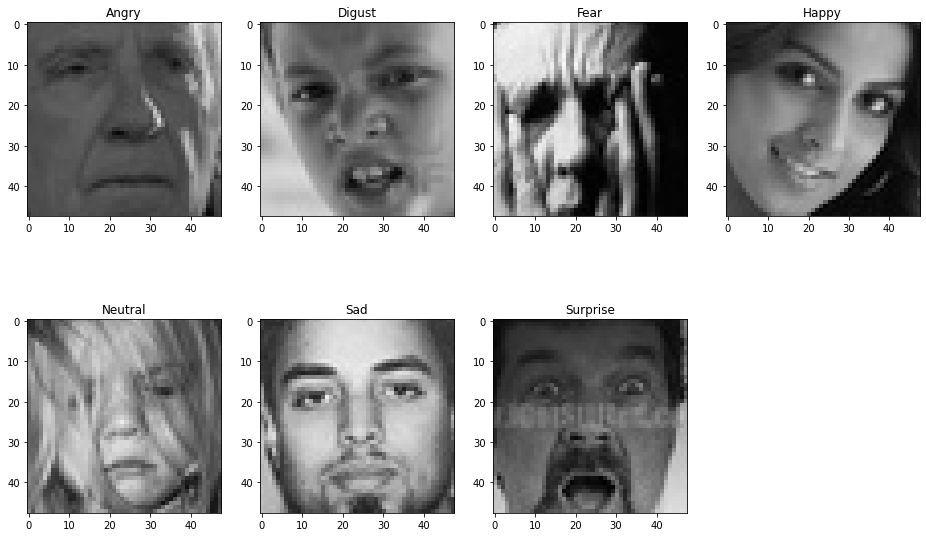

In [35]:
plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = test_data[test_data['label'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

In [36]:
X_test, Y_test = get_data(test_data)

Data X Shape: {}, Data Y Shape: (7178, 48, 48, 1)


In [40]:
score = best_model.evaluate(X_test, Y_test, verbose=0, batch_size=16)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

Test Loss: 1.002629280090332
Test accuracy: 0.6912789344787598


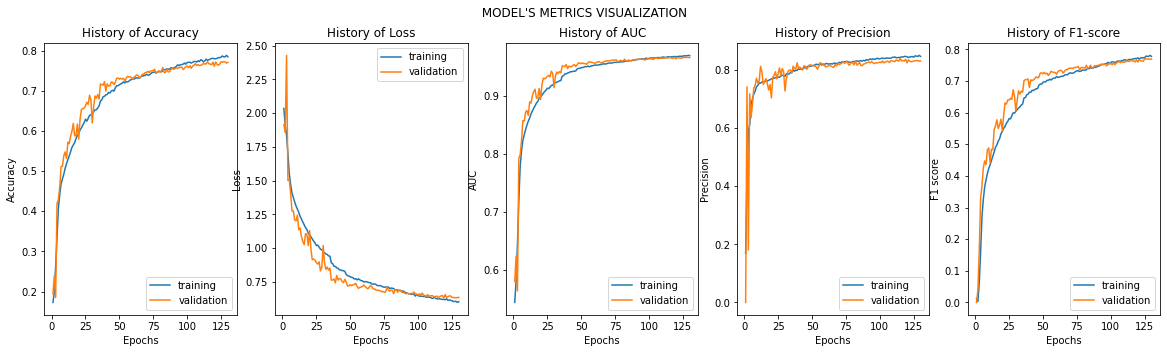

In [39]:

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history_1.history['accuracy'],history_1.history['val_accuracy'],
               history_1.history['loss'],history_1.history['val_loss'],
               history_1.history['auc'],history_1.history['val_auc'],
               history_1.history['precision'],history_1.history['val_precision'],
               history_1.history['f1_score'],history_1.history['val_f1_score']
              )

In [44]:
from sklearn.metrics import confusion_matrix
predict_x=best_model.predict(X_test) 
results=np.argmax(predict_x,axis=1)
# results = best_model.predict_classes(X_test)
cm = confusion_matrix(np.where(Y_test == 1)[1], results)

In [45]:
label_mapdisgust = ['Angry','Digust','Fear','Happy','Neutral','Sad','Surprise']

In [46]:
cm_df = pd.DataFrame(cm, index = label_mapdisgust,
                     columns = label_mapdisgust
                    )

final_cm = cm_df
final_cm


,Angry,Digust,Fear,Happy,Neutral,Sad,Surprise
Angry,616,3,75,35,106,112,11
Digust,22,70,4,4,5,5,1
Fear,153,0,481,47,116,174,53
Happy,26,1,18,1622,68,16,23
Neutral,74,2,41,88,902,116,10
Sad,147,0,109,63,259,656,13
Surprise,29,1,86,65,27,8,615


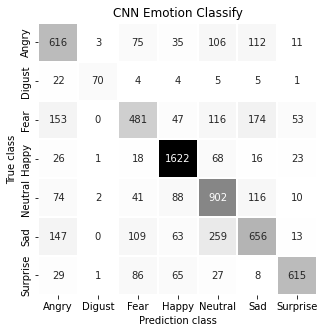

In [47]:
plt.figure(figsize = (5,5))
sns.heatmap(final_cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Emotion Classify')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()